In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

# ACS2 in Frozen Lake

About the environment
> The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

In [2]:
fl_env = gym.make('FrozenLake-v0')

# Reset the state
state = fl_env.reset()

# Render the environment
fl_env.render()


SFFF
FHFH
FFFH
HFFG


Each state might get following possible values: `{S, F, H, G}` which, refers to
```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```

In case of interacting with environment agent cant perform 4 action which map as follow:
- 0 - left
- 1 - down
- 2 - right
- 3 - up

> FrozenLake-v0 defines "solving" as getting average reward of 0.78 over 100 consecutive trials.

We will also define a second version of the same environment but with `slippery=False` parameters. That make it more deterministic.

In [3]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # optimum = .8196
)

fl_ns_env = gym.make('FrozenLakeNotSlippery-v0')

# Reset the state
state = fl_ns_env.reset()

# Render the environment
fl_ns_env.render()


SFFF
FHFH
FFFH
HFFG


## ACS2

In [4]:
# Import PyALCS code from local path
import sys, os
sys.path.append(os.path.abspath('../../..'))

from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

CLASSIFIER_LENGTH = 16  # Because we are operating in 4x4 grid
POSSIBLE_ACTIONS = fl_env.action_space.n  # 4

### Encoding perception
The only information back from the environment is the current agent position (not it's perception). Therefore our agent task will be to predicit where it will land after executing each action.

To do so we will represent state as a one-hot encoded vector.

In [5]:
class FrozenLakeAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        genotype = ['0' for i in range(CLASSIFIER_LENGTH)]
        genotype[phenotype] = 'X'
        return ''.join(genotype)

`X` corresponds to current agent position. State 4 is encoded as follows:

In [6]:
FrozenLakeAdapter().to_genotype(4)

'0000X00000000000'

### Environment metrics
We will also need a function for evaluating if agent finished succesfuly a trial

In [7]:
from lcs.metrics import population_metrics


# We assume if the final state was with number 15 that the algorithm found the reward. Otherwise not
def fl_metrics(pop, env):
    metrics = {
        'found_reward': env.env.s == 15,
    }
    
    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Performance evaluation

In [8]:
def print_performance(population, metrics):
    population.sort(key=lambda cl: -cl.fitness)
    population_count = len(population)
    reliable_count = len([cl for cl in population if cl.is_reliable()])
    successful_trials = sum(m['found_reward'] for m in metrics)

    print("Number of classifiers: {}".format(population_count))
    print("Number of reliable classifiers: {}".format(reliable_count))
    print("Percentage of successul trials: {:.2f}%".format(successful_trials / EXPLOIT_TRIALS  * 100))
    print("\nTop 10 classifiers:")
    for cl in population[:10]:
        print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f} \texp: {}".format(cl, cl.q, cl.r, cl.ir, cl.exp))

In [9]:
def plot_success_trials(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    success = [m['found_reward'] for m in metrics]

    ax.plot(trials, success)
    ax.set_title("Successful Trials")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Agent found reward")

In [10]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['numerosity'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='all')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

In [11]:
def plot_performance(metrics):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('Performance Visualization')
    
    ax1 = plt.subplot(221)
    plot_success_trials(metrics, ax1)
    
    ax2 = plt.subplot(222)
    plot_population(metrics, ax2)
    
    plt.show()

### Default ACS2 configuration
Right now we are ready to configure the ACS2 agent providing some defaults

In [12]:
cfg = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=POSSIBLE_ACTIONS,
    environment_adapter=FrozenLakeAdapter(),
    metrics_trial_frequency=1,
    user_metrics_collector_fcn=fl_metrics,
    theta_i=0.3,
    epsilon=0.7)

print(cfg)

ACS2Configuration:
	- Classifier length: [16]
	- Number of possible actions: [4]
	- Classifier wildcard: [#]
	- Environment adapter function: [<__main__.FrozenLakeAdapter object at 0x7fb730898f60>]
	- Do GA: [False]
	- Do subsumption: [True]
	- Do Action Planning: [False]
	- Beta: [0.05]
	- ...
	- Epsilon: [0.7]
	- U_max: [100000]


## Experiments

In [18]:
EXPLORE_TRIALS = 200
EXPLOIT_TRIALS = 100


def perform_experiment(cfg, env):
    # explore phase
    agent = ACS2(cfg)
    population_explore, metrics_explore = agent.explore(env, EXPLORE_TRIALS)
    
    # exploit phase, reinitialize agent with population above
    agent = ACS2(cfg, population=population_explore)
    population_exploit, metrics_exploit = agent.exploit(env, EXPLOIT_TRIALS)
    
    return (population_explore, metrics_explore), (population_exploit, metrics_exploit)

### FrozenLake-v0 environment (baseline)

random: 1
basic metrics: {'trial': 0, 'steps_in_trial': 4, 'reward': 0.0}
update {'trial': 0, 'steps_in_trial': 4, 'reward': 0.0} with {'found_reward': False, 'population': 3, 'numerosity': 3, 'reliable': 0}
basic metrics: {'trial': 1, 'steps_in_trial': 2, 'reward': 0.0}
update {'trial': 1, 'steps_in_trial': 2, 'reward': 0.0} with {'found_reward': False, 'population': 3, 'numerosity': 3, 'reliable': 0}
random: 3
random: 1
basic metrics: {'trial': 2, 'steps_in_trial': 4, 'reward': 0.0}
update {'trial': 2, 'steps_in_trial': 4, 'reward': 0.0} with {'found_reward': False, 'population': 5, 'numerosity': 5, 'reliable': 0}
random: 3
random: 2
basic metrics: {'trial': 3, 'steps_in_trial': 13, 'reward': 0.0}
update {'trial': 3, 'steps_in_trial': 13, 'reward': 0.0} with {'found_reward': False, 'population': 13, 'numerosity': 13, 'reliable': 0}
random: 0
random: 3
basic metrics: {'trial': 4, 'steps_in_trial': 12, 'reward': 0.0}
update {'trial': 4, 'steps_in_trial': 12, 'reward': 0.0} with {'found

basic metrics: {'trial': 50, 'steps_in_trial': 4, 'reward': 0.0}
update {'trial': 50, 'steps_in_trial': 4, 'reward': 0.0} with {'found_reward': False, 'population': 134, 'numerosity': 134, 'reliable': 0}
basic metrics: {'trial': 51, 'steps_in_trial': 3, 'reward': 0.0}
update {'trial': 51, 'steps_in_trial': 3, 'reward': 0.0} with {'found_reward': False, 'population': 133, 'numerosity': 133, 'reliable': 0}
basic metrics: {'trial': 52, 'steps_in_trial': 3, 'reward': 0.0}
update {'trial': 52, 'steps_in_trial': 3, 'reward': 0.0} with {'found_reward': False, 'population': 132, 'numerosity': 132, 'reliable': 0}
basic metrics: {'trial': 53, 'steps_in_trial': 9, 'reward': 0.0}
update {'trial': 53, 'steps_in_trial': 9, 'reward': 0.0} with {'found_reward': False, 'population': 134, 'numerosity': 134, 'reliable': 0}
basic metrics: {'trial': 54, 'steps_in_trial': 6, 'reward': 0.0}
update {'trial': 54, 'steps_in_trial': 6, 'reward': 0.0} with {'found_reward': False, 'population': 131, 'numerosity': 

basic metrics: {'trial': 100, 'steps_in_trial': 11, 'reward': 0.0}
update {'trial': 100, 'steps_in_trial': 11, 'reward': 0.0} with {'found_reward': False, 'population': 190, 'numerosity': 190, 'reliable': 0}
basic metrics: {'trial': 101, 'steps_in_trial': 11, 'reward': 0.0}
update {'trial': 101, 'steps_in_trial': 11, 'reward': 0.0} with {'found_reward': False, 'population': 191, 'numerosity': 191, 'reliable': 0}
basic metrics: {'trial': 102, 'steps_in_trial': 7, 'reward': 0.0}
update {'trial': 102, 'steps_in_trial': 7, 'reward': 0.0} with {'found_reward': False, 'population': 194, 'numerosity': 194, 'reliable': 0}
basic metrics: {'trial': 103, 'steps_in_trial': 4, 'reward': 0.0}
update {'trial': 103, 'steps_in_trial': 4, 'reward': 0.0} with {'found_reward': False, 'population': 193, 'numerosity': 193, 'reliable': 0}
basic metrics: {'trial': 104, 'steps_in_trial': 5, 'reward': 0.0}
update {'trial': 104, 'steps_in_trial': 5, 'reward': 0.0} with {'found_reward': False, 'population': 193, 

basic metrics: {'trial': 140, 'steps_in_trial': 4, 'reward': 0.0}
update {'trial': 140, 'steps_in_trial': 4, 'reward': 0.0} with {'found_reward': False, 'population': 210, 'numerosity': 210, 'reliable': 0}
basic metrics: {'trial': 141, 'steps_in_trial': 5, 'reward': 0.0}
update {'trial': 141, 'steps_in_trial': 5, 'reward': 0.0} with {'found_reward': False, 'population': 209, 'numerosity': 209, 'reliable': 0}
basic metrics: {'trial': 142, 'steps_in_trial': 27, 'reward': 0.0}
update {'trial': 142, 'steps_in_trial': 27, 'reward': 0.0} with {'found_reward': False, 'population': 209, 'numerosity': 209, 'reliable': 0}
basic metrics: {'trial': 143, 'steps_in_trial': 11, 'reward': 0.0}
update {'trial': 143, 'steps_in_trial': 11, 'reward': 0.0} with {'found_reward': False, 'population': 210, 'numerosity': 210, 'reliable': 0}
basic metrics: {'trial': 144, 'steps_in_trial': 9, 'reward': 0.0}
update {'trial': 144, 'steps_in_trial': 9, 'reward': 0.0} with {'found_reward': False, 'population': 211, 

basic metrics: {'trial': 180, 'steps_in_trial': 18, 'reward': 0.0}
update {'trial': 180, 'steps_in_trial': 18, 'reward': 0.0} with {'found_reward': False, 'population': 228, 'numerosity': 228, 'reliable': 0}
basic metrics: {'trial': 181, 'steps_in_trial': 26, 'reward': 0.0}
update {'trial': 181, 'steps_in_trial': 26, 'reward': 0.0} with {'found_reward': False, 'population': 230, 'numerosity': 230, 'reliable': 0}
basic metrics: {'trial': 182, 'steps_in_trial': 8, 'reward': 0.0}
update {'trial': 182, 'steps_in_trial': 8, 'reward': 0.0} with {'found_reward': False, 'population': 230, 'numerosity': 230, 'reliable': 0}
basic metrics: {'trial': 183, 'steps_in_trial': 16, 'reward': 0.0}
update {'trial': 183, 'steps_in_trial': 16, 'reward': 0.0} with {'found_reward': False, 'population': 230, 'numerosity': 230, 'reliable': 0}
basic metrics: {'trial': 184, 'steps_in_trial': 7, 'reward': 0.0}
update {'trial': 184, 'steps_in_trial': 7, 'reward': 0.0} with {'found_reward': False, 'population': 230

basic metrics: {'trial': 24, 'steps_in_trial': 62, 'reward': 0.0}
update {'trial': 24, 'steps_in_trial': 62, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 25, 'steps_in_trial': 10, 'reward': 0.0}
update {'trial': 25, 'steps_in_trial': 10, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 26, 'steps_in_trial': 24, 'reward': 0.0}
update {'trial': 26, 'steps_in_trial': 24, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 27, 'steps_in_trial': 3, 'reward': 0.0}
update {'trial': 27, 'steps_in_trial': 3, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 28, 'steps_in_trial': 29, 'reward': 0.0}
update {'trial': 28, 'steps_in_trial': 29, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numer

basic metrics: {'trial': 66, 'steps_in_trial': 100, 'reward': 0.0}
update {'trial': 66, 'steps_in_trial': 100, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 67, 'steps_in_trial': 23, 'reward': 0.0}
update {'trial': 67, 'steps_in_trial': 23, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 68, 'steps_in_trial': 45, 'reward': 0.0}
update {'trial': 68, 'steps_in_trial': 45, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 69, 'steps_in_trial': 100, 'reward': 0.0}
update {'trial': 69, 'steps_in_trial': 100, 'reward': 0.0} with {'found_reward': False, 'population': 239, 'numerosity': 239, 'reliable': 0}
basic metrics: {'trial': 70, 'steps_in_trial': 36, 'reward': 0.0}
update {'trial': 70, 'steps_in_trial': 36, 'reward': 0.0} with {'found_reward': False, 'population': 239, 

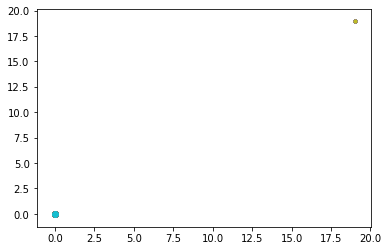

In [19]:
%%time
explore_results, exploit_results = perform_experiment(cfg, fl_env) 

Learn some behaviour during exploration phase

In [15]:
# exploration
print_performance(explore_results[0], explore_results[1])

Number of classifiers: 577
Number of reliable classifiers: 5
Percentage of successul trials: 46.00%

Top 10 classifiers:
##########0###X# 2 ##########X###0# (0000000000#000#0)    q: 0.643 r: 0.7304 ir: 0.695  f: 0.4699 exp: 35  tga: 1638  talp: 15949 tav: 3.86e+02 num: 1 	q: 0.64 	r: 0.73 	ir: 0.69 	exp: 35
0#########0###X# 2 ##########X###0# (#000000000#000#0)    q: 0.616 r: 0.7239 ir: 0.6886 f: 0.4461 exp: 31  tga: 4819  talp: 15949 tav: 3.46e+02 num: 1 	q: 0.62 	r: 0.72 	ir: 0.69 	exp: 31
0#######0#0###X# 2 ##########X###0# (#0000000#0#000#0)    q: 0.615 r: 0.7104 ir: 0.6764 f: 0.4367 exp: 18  tga: 9320  talp: 15949 tav: 3.55e+02 num: 1 	q: 0.61 	r: 0.71 	ir: 0.68 	exp: 18
##############X# 2 ################ (00000000000000#0)    q: 0.552 r: 0.7113 ir: 0.6777 f: 0.3927 exp: 21  tga: 9046  talp: 15949 tav: 3.12e+02 num: 1 	q: 0.55 	r: 0.71 	ir: 0.68 	exp: 21
0#######0#####X# 2 ################ (#0000000#00000#0)    q: 0.509 r: 0.7104 ir: 0.6764 f: 0.3615 exp: 20  tga: 9104  talp: 159

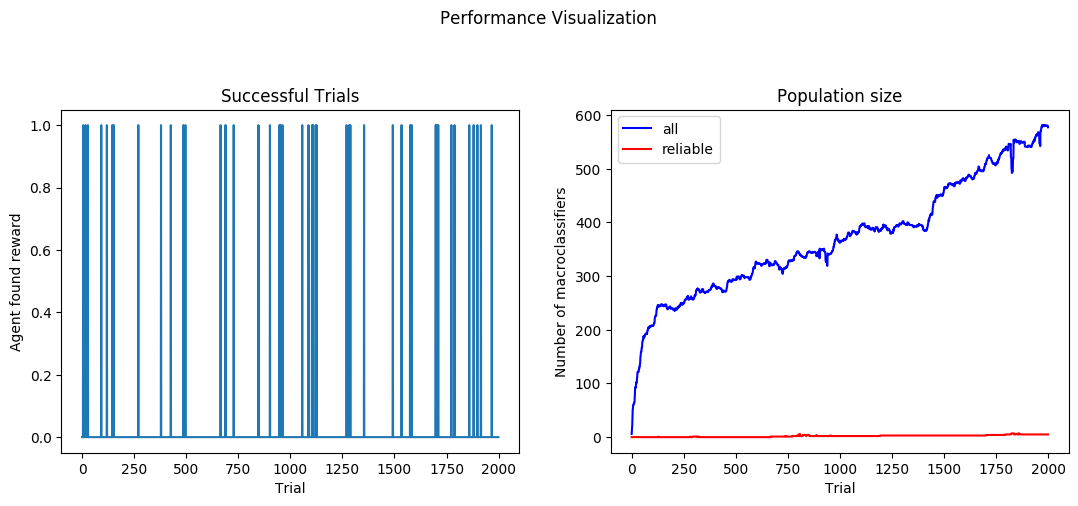

In [16]:
plot_performance(explore_results[1])

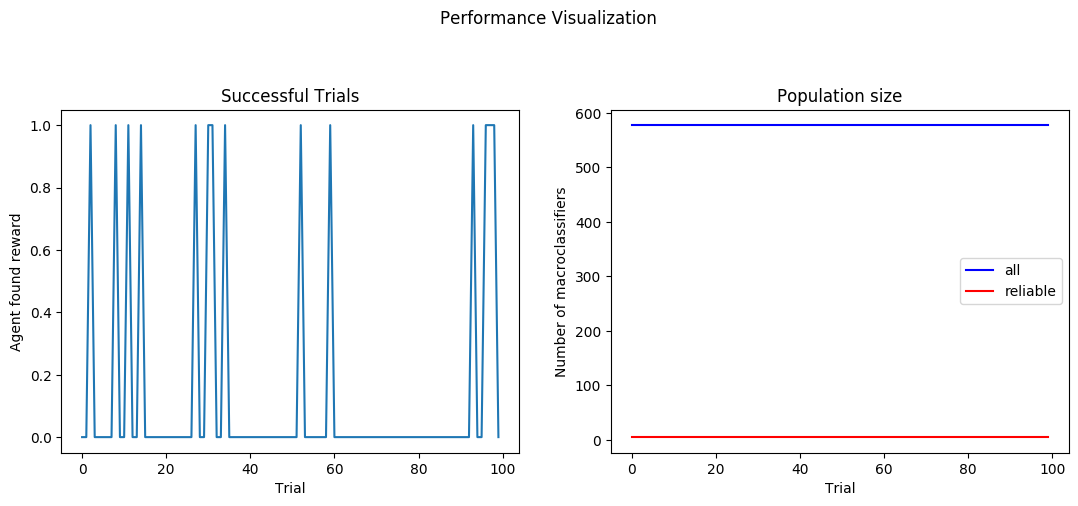

In [17]:
plot_performance(exploit_results[1])

Metrics from exploitation

In [17]:
# exploitation
print_performance(exploit_results[0], exploit_results[1])

Number of classifiers: 522
Number of reliable classifiers: 3
Percentage of successul trials: 41.00%

Top 10 classifiers:
000######0###0X# 1 #############X0# (###000000#000##0)    q: 0.636 r: 0.9285 ir: 0.9156 f: 0.5905 exp: 45  tga: 2741  talp: 16868 tav: 2.7e+02 num: 1 	q: 0.64 	r: 0.93 	ir: 0.92 	exp: 45
000#0#####0##0X# 1 #############X0# (###0#00000#00##0)    q: 0.615 r: 0.9244 ir: 0.9119 f: 0.5683 exp: 30  tga: 7934  talp: 16868 tav: 2.75e+02 num: 1 	q: 0.61 	r: 0.92 	ir: 0.91 	exp: 30
000#0#####0###X# 1 ################ (###0#00000#000#0)    q: 0.526 r: 0.9244 ir: 0.9119 f: 0.4859 exp: 31  tga: 7879  talp: 16868 tav: 2.66e+02 num: 1 	q: 0.53 	r: 0.92 	ir: 0.91 	exp: 31
000######0####X# 1 ################ (###000000#0000#0)    q: 0.521 r: 0.9285 ir: 0.9156 f: 0.4835 exp: 50  tga: 1345  talp: 16868 tav: 2.63e+02 num: 1 	q: 0.52 	r: 0.93 	ir: 0.92 	exp: 50
#############0X# 1 #############X0# (0000000000000##0)    q: 0.51  r: 0.9288 ir: 0.916  f: 0.4737 exp: 55  tga: 333   talp: 1686

### FrozenLakeNotSlippery-v0 environment

random: 0
random: 1
random: 1
random: 2
random: 1
random: 0
random: 1
random: 3
random: 0
CPU times: user 1min 38s, sys: 7.92 s, total: 1min 46s
Wall time: 1min 32s


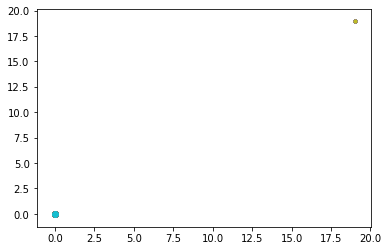

In [18]:
%%time
explore_results_2, exploit_results_2 = perform_experiment(cfg, fl_ns_env)

In [28]:
# exploration
print_performance(explore_results_2[0], explore_results_2[1])

Number of classifiers: 109
Number of reliable classifiers: 106
Percentage of successul trials: 204.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x113765cf8 	q: 1.00 	r: 1.00 	ir: 1.00 	exp: 203
#############X0#-2-#############0X# @ 0x113789c18 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 247
##########X###0#-1-##########0###X# @ 0x113714748 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 158
##############X#-1-################ @ 0x1137bbac8 	q: 1.00 	r: 0.94 	ir: 0.00 	exp: 105
#########X###0##-1-#########0###X## @ 0x113789048 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 370
#########X0#####-2-#########0X##### @ 0x1137bb6d8 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 169
#############X##-1-################ @ 0x1137bba58 	q: 1.00 	r: 0.89 	ir: 0.00 	exp: 121
#00######0###0X#-0-#############X0# @ 0x1137bb080 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 92
##########0###X#-3-##########X###0# @ 0x113a6b0b8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 110
#00##########0X#-0-#############X0# @ 0x1137892e8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 9

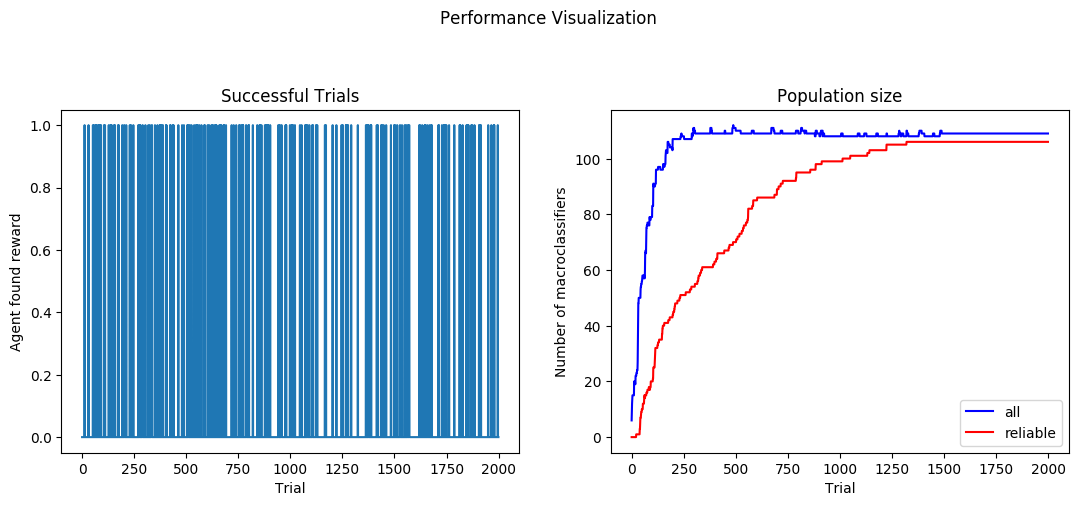

In [29]:
plot_performance(explore_results_2[1])

In [30]:
# exploitation
print_performance(exploit_results_2[0], exploit_results_2[1])

Number of classifiers: 109
Number of reliable classifiers: 106
Percentage of successul trials: 100.00%

Top 10 classifiers:
##############X0-2-##############0X @ 0x113765cf8 	q: 1.00 	r: 1.00 	ir: 1.00 	exp: 203
#############X0#-2-#############0X# @ 0x113789c18 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 247
##########X###0#-1-##########0###X# @ 0x113714748 	q: 1.00 	r: 0.95 	ir: 0.00 	exp: 158
##############X#-1-################ @ 0x1137bbac8 	q: 1.00 	r: 0.94 	ir: 0.00 	exp: 105
#########X###0##-1-#########0###X## @ 0x113789048 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 370
#########X0#####-2-#########0X##### @ 0x1137bb6d8 	q: 1.00 	r: 0.90 	ir: 0.00 	exp: 169
#############X##-1-################ @ 0x1137bba58 	q: 1.00 	r: 0.89 	ir: 0.00 	exp: 121
#00######0###0X#-0-#############X0# @ 0x1137bb080 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 92
##########0###X#-3-##########X###0# @ 0x113a6b0b8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 110
#00##########0X#-0-#############X0# @ 0x1137892e8 	q: 1.00 	r: 0.88 	ir: 0.00 	exp: 9

## Comparison

In [31]:
def plot_population(metrics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    trials = [m['trial'] for m in metrics]
    
    population_size = [m['numerosity'] for m in metrics]
    reliable_size = [m['reliable'] for m in metrics]
    
    ax.plot(trials, population_size, 'b', label='all')
    ax.plot(trials, reliable_size, 'r', label='reliable')
    
    ax.set_title("Population size")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Number of macroclassifiers")
    ax.legend(loc='best')

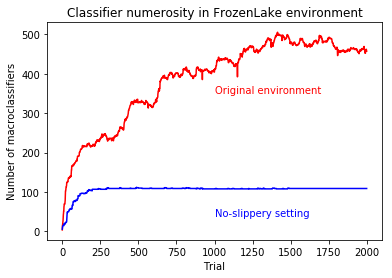

In [32]:
original = explore_results[1]
modified = explore_results_2[1]

ax = plt.gca()

trials = [m['trial'] for m in original]

original_numerosity = [m['numerosity'] for m in original]
modified_numerosity = [m['numerosity'] for m in modified]

ax.plot(trials, original_numerosity, 'r')
ax.text(1000, 350, "Original environment", color='r')

ax.plot(trials, modified_numerosity, 'b')
ax.text(1000, 40, 'No-slippery setting', color='b')


ax.set_title('Classifier numerosity in FrozenLake environment')
ax.set_xlabel('Trial')
ax.set_ylabel('Number of macroclassifiers')

plt.show()